# **Transformer Intuitiont Math => Code**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

from IPython.display import Image

# Architecture

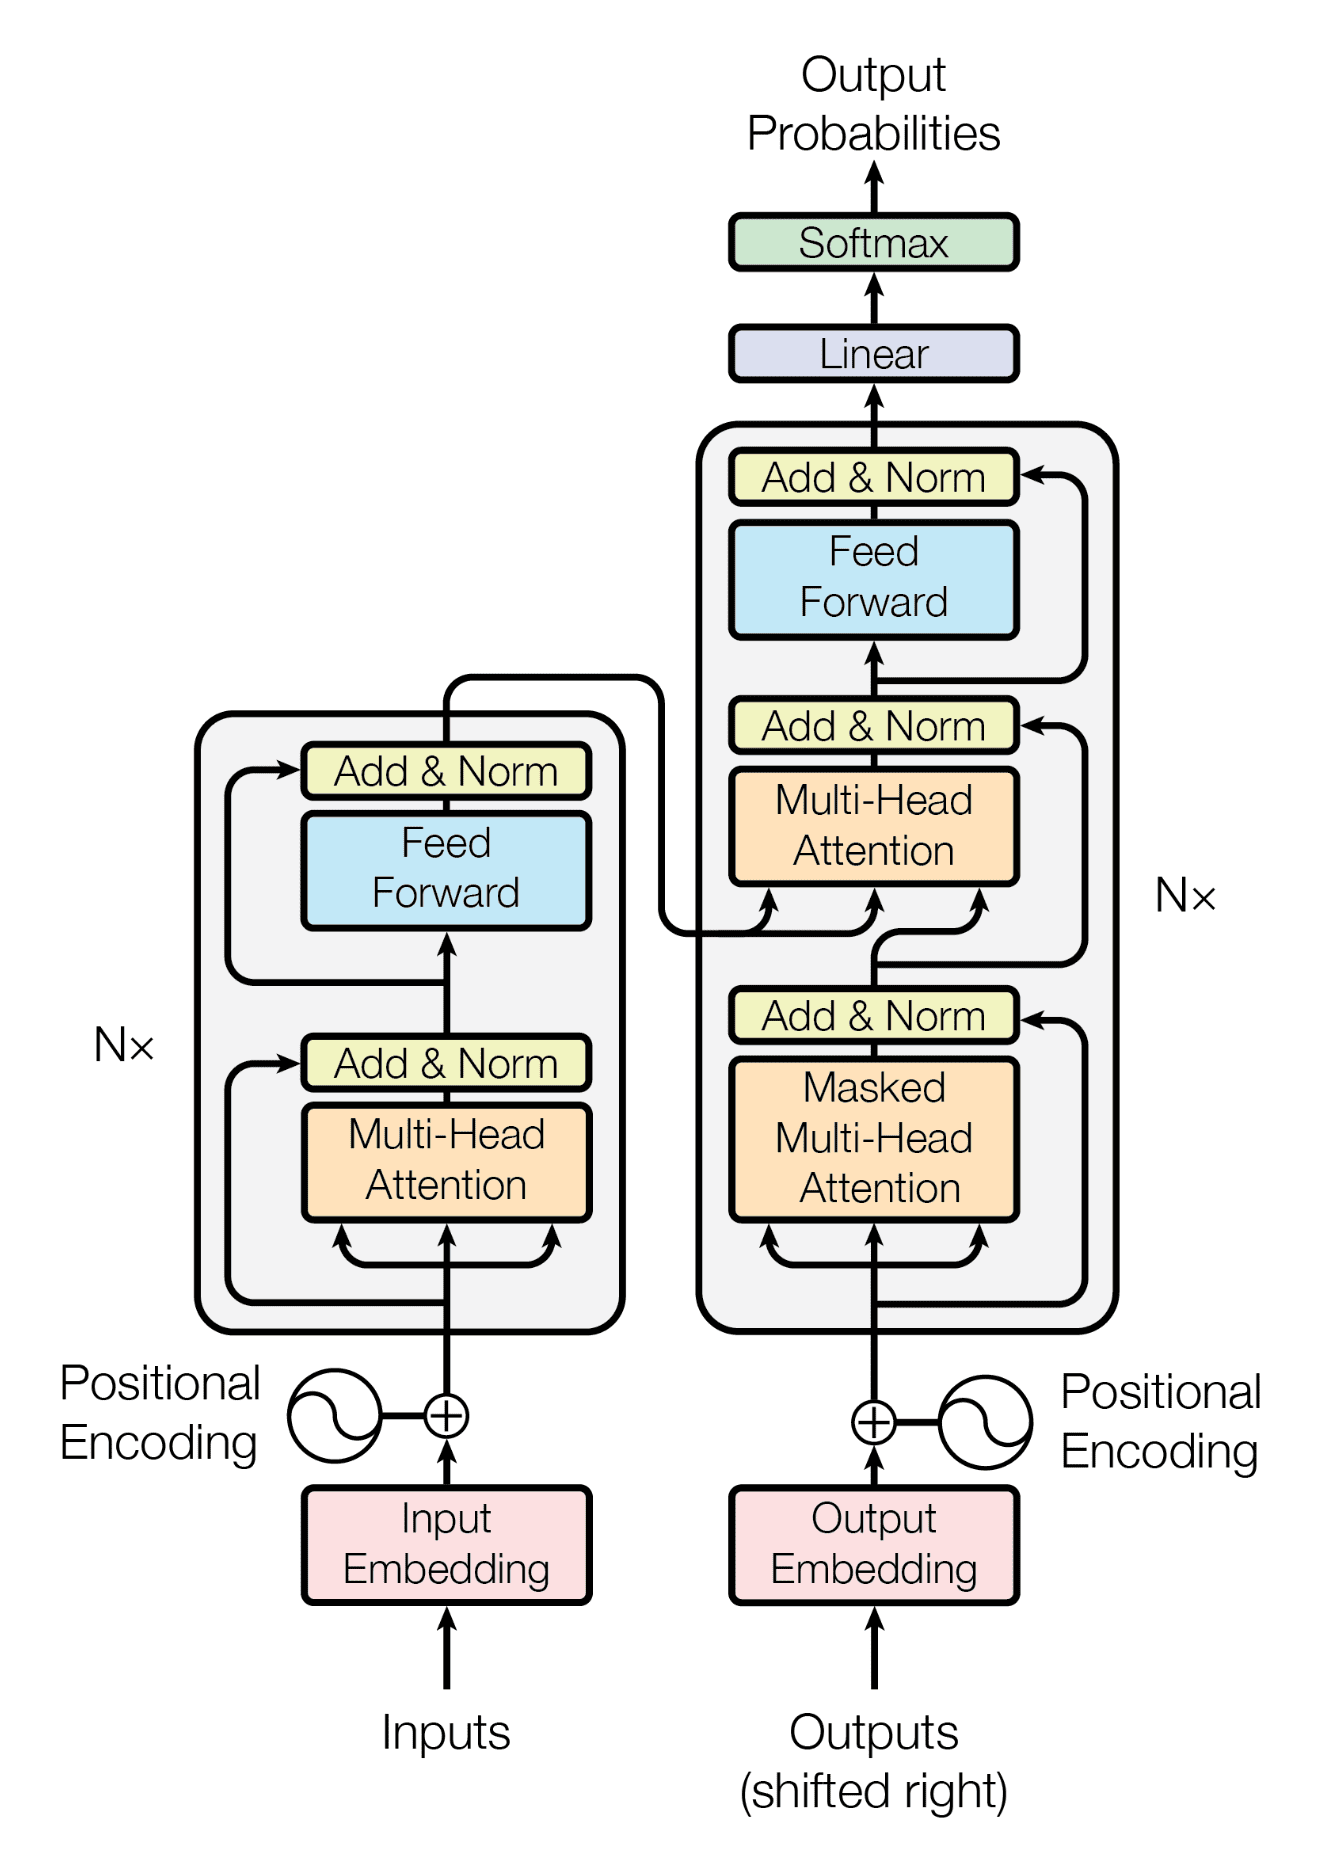

In [2]:
Image("TransformerArchitecture.webp", width=300)

# Encoder - Left Block

### Positional Encoding

**Purpose?**
- Transformers process all tokens in parallel, so they **don’t inherently preserve the order** of tokens in a sequence, which means that they lack some level sequential structure

**What is it?**

- **Positional encoding** is a technique that injects information about token order into the model by adding a vector to each token embedding.
- This allows the model to **differentiate between the same token appearing in different positions**, effectively reintroducing sequence order.

Slow Implementation -> Easy to Understand

In [29]:
def positional_encoding_slow(embeddings):
    """
    Computes the positional encodings of the inputted vectors into the encoder block for the transformer

    Expects to recieve some type of input matrix: E of dimension n x d
        -> n represents the number of inputted token embeddings
        -> d represents the embedding dimension: typically 512 from the novel Attention paper
    """

    # >>>>>>>>>>>>>>>>>>
    # INEFFICIENT METHOD
    # >>>>>>>>>>>>>>>>>>


    # Holds our positional vectors that will later be converted into a tensor of dimension n x d or number of inputs x dimension of the embedding
    p_ordered = [] 
    for position in range(len(embeddings)):
        pvec = []
        for i in range(len(embeddings[position])):
            inner = position / torch.pow(torch.tensor(10000.0), torch.tensor((2 * i) / len(embeddings[position])))
            if position%2 == 0:
                pe = torch.sin(inner)
            else:
                pe = torch.cos(inner)
            pvec.append(pe)
        pvec = torch.stack(pvec)
        p_ordered.append(pvec)

    p_ordered = torch.stack(p_ordered)
    # Using the additive property we can inject positional information into the embeddings, so now they have some type of "chronological" order innately held
    res = embeddings + p_ordered

Faster

In [ ]:
def positional_encoding_fast(embeddings):
    # >>>>>>>>>>>>>>>>>>
    # EFFICIENT METHOD = Uses Vectorization this time
    # >>>>>>>>>>>>>>>>>>

    n, d = embeddings.shape

    positional_indices = torch.arange(n, dtype=torch.float32).unsqueeze(1)
    Iidx = torch.arange(d, dtype=torch.float32).unsqueeze(0)

    frequencies = 1 / torch.pow(10000, (2 * Iidx) / d)

    positional_encodings = torch.mul(positional_indices, frequencies)

    positional_encodings[:, 0::2] = torch.sin(positional_encodings[:, 0::2])
    positional_encodings[:, 1::2] = torch.cos(positional_encodings[:, 1::2])


    enriched = embeddings + positional_encodings

    return positional_encodings, enriched

test = torch.ones(5, 5)
print(f"Original Embeddings: {test}")
pos_embed, enriched = positional_encoding_fast(test)

print(f"Positional Embeddings: {pos_embed}")
print(f"Enriched/Combined: {enriched}")

Original Embeddings: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
Positional Embeddings: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.5119e-02, 6.3096e-04, 1.5849e-05, 3.9811e-07],
        [2.0000e+00, 5.0238e-02, 1.2619e-03, 3.1698e-05, 7.9621e-07],
        [3.0000e+00, 7.5357e-02, 1.8929e-03, 4.7547e-05, 1.1943e-06],
        [4.0000e+00, 1.0048e-01, 2.5238e-03, 6.3396e-05, 1.5924e-06]])
Enriched/Combined: tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [2.0000, 1.0251, 1.0006, 1.0000, 1.0000],
        [3.0000, 1.0502, 1.0013, 1.0000, 1.0000],
        [4.0000, 1.0754, 1.0019, 1.0000, 1.0000],
        [5.0000, 1.1005, 1.0025, 1.0001, 1.0000]])


##### Deep Questions (?)

(1) What is the purpose of the inner variable?
- "inner" is basically the usage of exponentially calculated frequencies that are are then multiplied (*) by the position, so that complex positions can be found geometrically.

(2) Why multiply the position and the frequency term together inside the cos or sin function?
- This is an interesting question because it connects to the idea that we don't want extremely large positional values in our positional vector that we will later add. If you can imagine an embedding dimension of 512, and that we multiply at "max" 512 * cos(frequency) then we might overshadow the actual embedding with extremely large sparse positional values.
- The more interesting idea is that pi and 2pi actually have the same trig function outputs right, BUT this only occurs under a constant frequency, so by creating both a dynamic position and frequency value and by passing them into a bounded function, we can now ensure that every positional value is unique and conveys different information. This allows for an even richer embedding

(3) What would happen if we utilized other functions like tanh?
- Quite easy to see honestly because we know that tanh after some point just goes to inf or -inf, and it doesn't showcase the same repetitive periodic behaviour as sin and cos